In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip
import math
from scipy.stats import t
from ast import literal_eval
import re

import stat_tests

# Exploratory Data Analysis

# Step 1. Find observed difference in male and female subjects

In [2]:
# load in data
data_file = 'Data/data_clean.csv.gz'

with gzip.open(data_file) as filepath:
    data = pd.read_csv(filepath, index_col = 'subject_id', 
            converters = {'netmat' : lambda x : np.array(literal_eval(re.sub('(?<!\[)\s+|[\\n]', ', ', x)))})
    
data.head()

,Gender,Age,netmat
subject_id,,,
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."


In [3]:
sex = "Gender" # column name for male or female assignment
netmat = "netmat"

df = data[[sex, netmat]]

m = "M"
f = "F"
male_df = df[df[sex] == m] # get all males
female_df = df[df[sex] == f] # get all females

avg_netmat = df.groupby(sex).mean()[netmat] # find element-wise averages in male correlation matrix and female correlation matrix
m_avg_netmat = avg_netmat.loc[m]
f_avg_netmat = avg_netmat.loc[f]

diff_avg_netmat = m_avg_netmat - f_avg_netmat # find element-wise difference in averages between male and female correlation matrix (M - F)

## Aggregated Pairwise Correlation Matrices

In [4]:
num_males = male_df.shape[0]
num_females = female_df.shape[0]
print(f"Below are the correlation matrices found by performing element-wise averages on each unique pairwise correlation value \nfor all {num_males} males, and again for all {num_females} females.")

Below are the correlation matrices found by performing element-wise averages on each unique pairwise correlation value 
for all 469 males, and again for all 534 females.


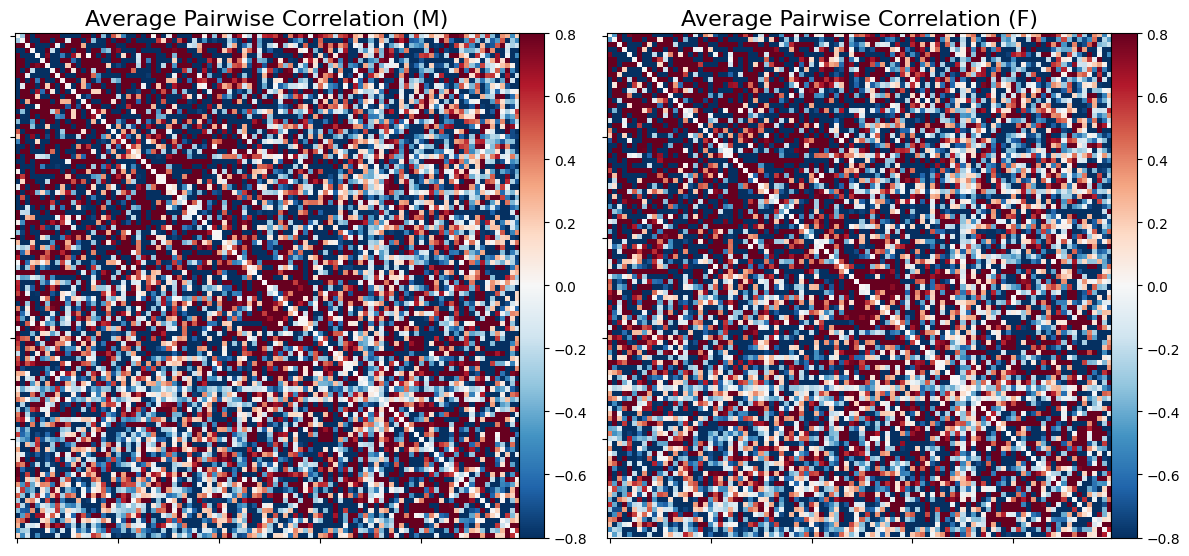

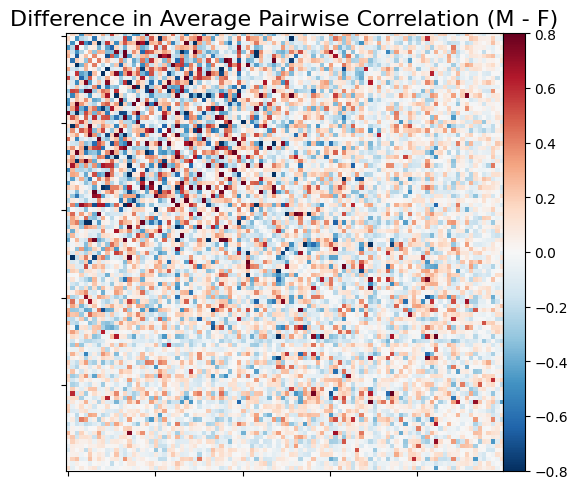

In [5]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plotting.plot_matrix( # visualize element-wise average of males
    m_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, axes=axes[0], title = "Average Pairwise Correlation (M)")


plotting.plot_matrix( # visualize element-wise average of females
    f_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, axes=axes[1], title = "Average Pairwise Correlation (F)")


plotting.plot_matrix( # visualize element-wise difference of averages
    diff_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, title = "Difference in Average Pairwise Correlation (M - F)")

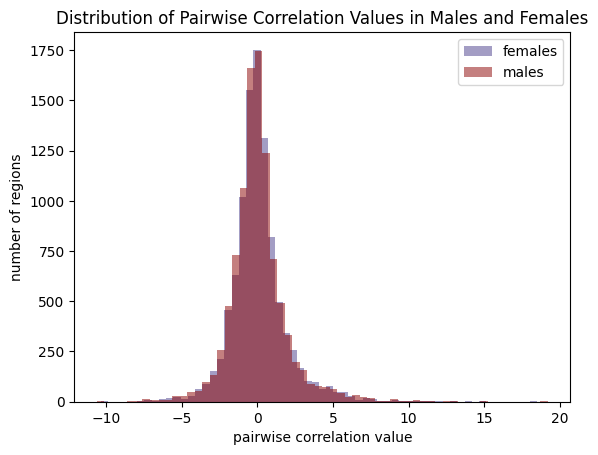

In [6]:
bins = 60
plt.hist(m_avg_netmat.flatten(), bins=bins, label="females", alpha=0.5, color="darkslateblue")
plt.hist(f_avg_netmat.flatten(), bins=bins, label="males", alpha=0.5, color="darkred")

plt.xlabel('pairwise correlation value')
plt.ylabel('number of regions')
plt.title('Distribution of Pairwise Correlation Values in Males and Females')
plt.legend()

plt.show()

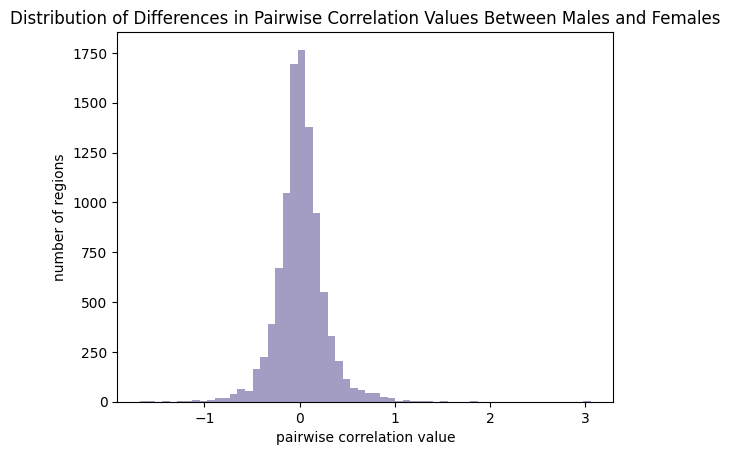

In [7]:
plt.hist(diff_avg_netmat.flatten(), bins=bins, alpha=0.5, color="darkslateblue")

plt.xlabel('pairwise correlation value')
plt.ylabel('number of regions')
plt.title('Distribution of Differences in Pairwise Correlation Values Between Males and Females')

plt.show()

We are interested in whether there is a difference in male and female fMRI resting state data. In order to test this difference, we compare the pairwise correlation matrices of roughly 500 male subject and 500 female subjects. We aggregated the male subjects' and the female subjects' pairwise correlation matrices into a single matrix that contains the average correlation for each of the unique pairwise regions.  
  
To further explore the possible differences in male and female fMRI resting state data, we represented the averaged correlation matrices for each sex as a histogram and found that, to the naked eye, there are no visually obvious differences between male and female fMRI resting state data.  
  
However, we can conduct a more formal test that better quantifies whether the observed difference between male and female data is statistically significant.

# Step 2. Perform Statistical Tests

## I. Conducting a Two-Sided Independent Samples $t$-Test

### A. Check Assumptions

Here, we must check a few assumptions about our data before conducting a two-sample t-test.   
*note that we are using Welch's t-test, which does not assume that the two populations have the same variance**

1. Populations are independent of one another.
    - We know that male pairwise correlation matrices are independent from female pairwise correlation matrices.  
2. Populations are normally distributed.
    - The Fischer Transform of correlation values produces gaussian distributions for each pairwise region across all subjects in the respective sex.  
3. Data within each population are independent.
    - We know that the correlation matrices of same-sex subjects are independent from eahcother.
    

### B. Perform $t$-Test

Here, we conduct an two-sample t-test that quantifies whether the observed difference between male and female fMRI data is statistically significant.  
  
To conduct an two-sample t-test, we begin by defining a Null Hypothesis and Alternative Hypothesis:  
- Null Hypothesis ($H_0$): Male and female fMRI resting state data are not different.
    - The average correlation matrix of all males and the average correlation matrix of all females have a difference of 0.
    - $\mu_{Male} - \mu_{Female} = 0$
- Alternative Hypothesis ($H$): Male and female fMRI resting state data are different.
    - The average correlation matrix of all males and the average correlation matrix of all females do not have a difference of 0.
    - $\mu_{Male} - \mu_{Female} \neq 0$


In [8]:
male_netmats = male_df[netmat].to_numpy()
female_netmats = female_df[netmat].to_numpy()
t_stats, m_f_sqse, t_p_vals = stat_tests.get_tstats(male_netmats, female_netmats)

c:\Users\dfabe\Documents\GitHub\DSC180B-Capstone-ProjectA09\stat_tests.py:37: RuntimeWarning: invalid value encountered in divide
  t_stats = diff_means / overall_se


### C. Identify Statistically Significant Pairwise Correlations

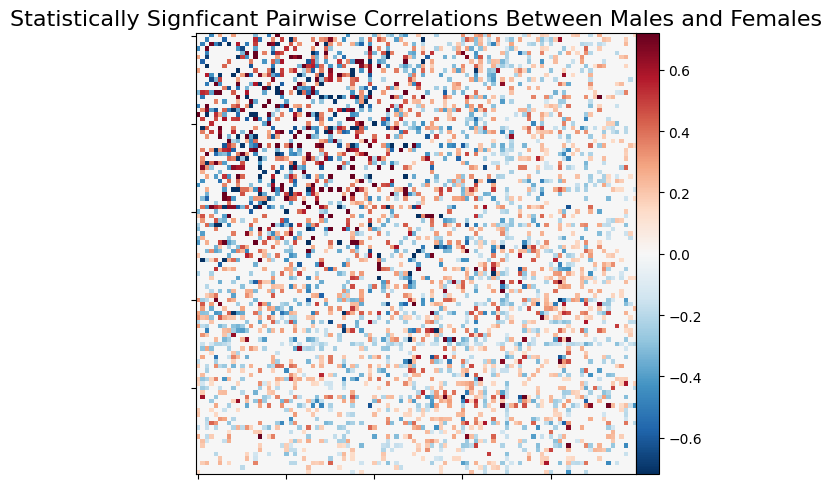

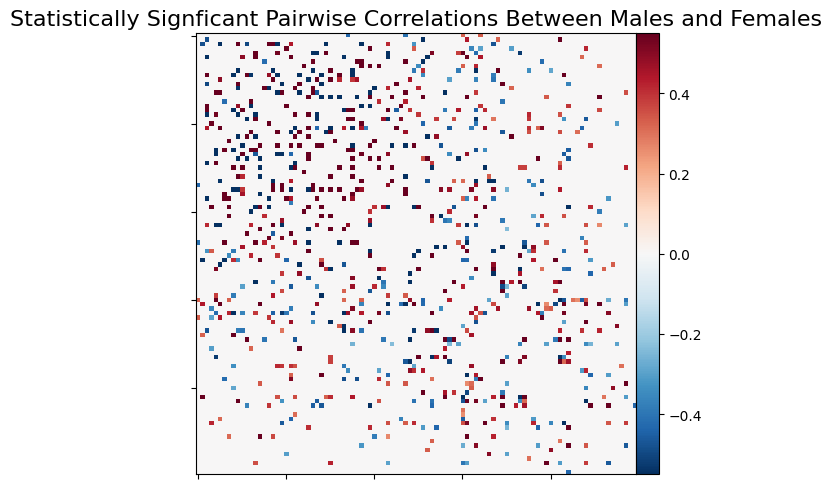

In [11]:
alpha = 0.01

num_regions = diff_avg_netmat.shape[0]
num_pairwise_regions = math.comb(num_regions, 2)
bonferroni_alpha = alpha / num_pairwise_regions # bonferroni correction

t_significant_regions = stat_tests.get_sig_regions(diff_avg_netmat, t_p_vals, alpha)
t_significant_regions_bonferroni = stat_tests.get_sig_regions(diff_avg_netmat, t_p_vals, bonferroni_alpha)

In [12]:
print(f"Of the {num_pairwise_regions} pairwise correlations, {(t_significant_regions_bonferroni != 0).sum() / 2} are statistically significant under the alpha={bonferroni_alpha}.")
print(f"{(t_significant_regions != 0).sum() / 2} are statistically significant under the alpha={alpha}.")

Of the 4950 pairwise correlations, 427.0 are statistically significant under the alpha=2.02020202020202e-06.
1695.0 are statistically significant under the alpha=0.01.


In [24]:
bonferroni_significant_edges = np.where(t_significant_regions_bonferroni == 0, 0, True)
significant_edges = np.where(t_significant_regions == 0, 0, True)
np.savetxt("bonferroni_sig_edges.csv", bonferroni_significant_edges, delimiter=",")
np.savetxt("significant_edges.csv", significant_edges, delimiter=",")

## Step 3. Exploratory Values

Of all unique pairwise regions, what proportion of them have statistically significant differences in correlation between males and females?

In [15]:
def set_upper_triangular(symmetric_matrix):
    '''returns only the upper triangular values of a symmetric matrix'''
    num_pairwise = symmetric_matrix.shape[0]
    no_diagonal = 1

    new_matrix = symmetric_matrix.copy()
    new_matrix[np.tril_indices(n=num_pairwise, k=no_diagonal)] = 0
    return new_matrix

def get_upper_triangular(symmetric_matrix):
    """
    Returns only the upper triangular values of a symmetric matrix
    """
    num_pairwise = symmetric_matrix.shape[0]
    no_diagonal = 1
    return symmetric_matrix[np.triu_indices(n=num_pairwise, k=no_diagonal)]

In [16]:
1 - (get_upper_triangular(t_significant_regions_bonferroni) == 0).mean() # proportion of all pairwise regions that have statistically significant difference

0.08626262626262626

How much of the overall difference between males and females is attributable to the pairwise regions with statistically significant differences in correlation between males and females?

In [17]:
np.linalg.norm(t_significant_regions_bonferroni) / np.linalg.norm(diff_avg_netmat) # proportion of the overall difference attributable to significant regions


0.7135527629984316

## Pairwise Regions with Statistically Significant Different Correlation Values Between Males and Females

In [18]:
m_significant_regions = np.where(t_significant_regions_bonferroni == 0, 0, m_avg_netmat)
f_significant_regions = np.where(t_significant_regions_bonferroni == 0, 0, f_avg_netmat)

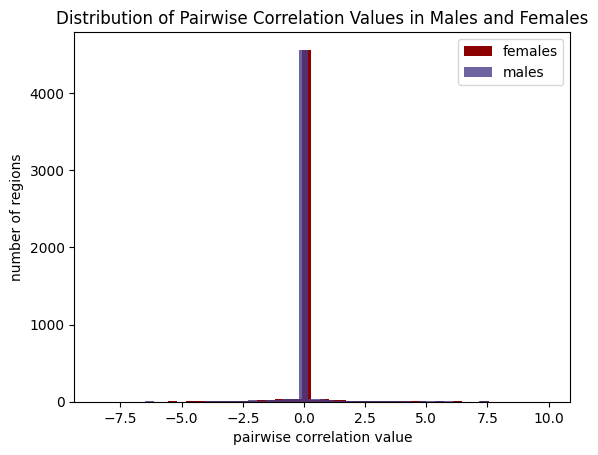

In [19]:
bins = 50
plt.hist(get_upper_triangular(f_significant_regions).flatten(), bins=bins, label="females", color="darkred")
plt.hist(get_upper_triangular(m_significant_regions).flatten(), bins=bins, label="males", alpha=0.8, color="darkslateblue")

plt.xlabel('pairwise correlation value')
plt.ylabel('number of regions')
plt.title('Distribution of Pairwise Correlation Values in Males and Females')
plt.legend()

plt.show()

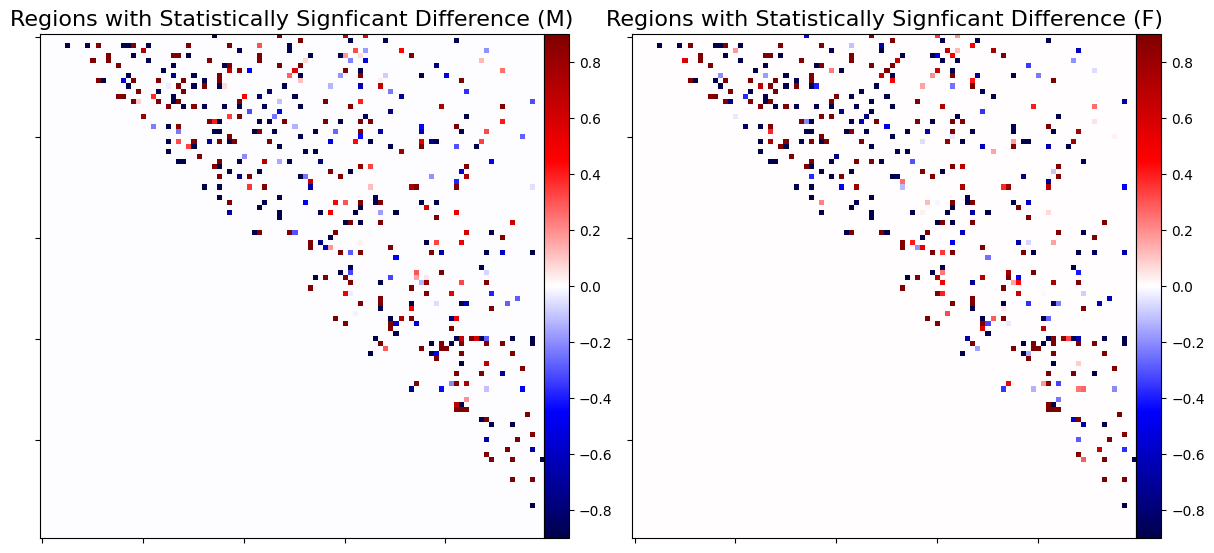

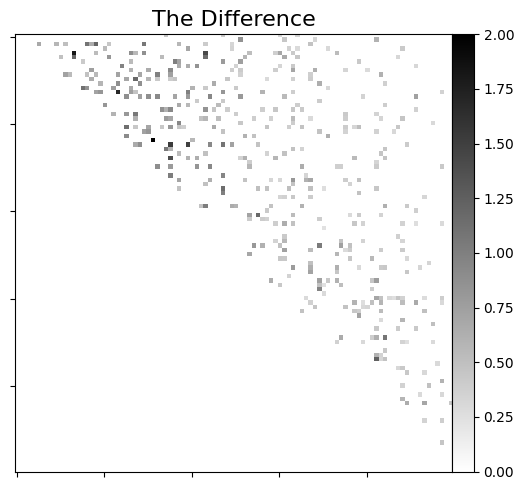

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(m_significant_regions), colorbar=True, vmax=0.9, vmin=-0.9, axes=axes[0], title = "Regions with Statistically Signficant Difference (M)", cmap='seismic')
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(f_significant_regions), colorbar=True, vmax=0.9, vmin=-0.9, axes=axes[1], title = "Regions with Statistically Signficant Difference (F)", cmap='seismic')
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(np.abs(m_significant_regions - f_significant_regions)), colorbar=True, vmax=2, vmin=0, title = "The Difference", cmap='binary')

## Pairwise Regions with Lowest P-Value

In [21]:
lowest_t_pvals = np.isclose(t_p_vals, np.min(t_p_vals))
m_most_diff = set_upper_triangular(np.where(lowest_t_pvals, m_significant_regions, 0))
f_most_diff = set_upper_triangular(np.where(lowest_t_pvals, f_significant_regions, 0))

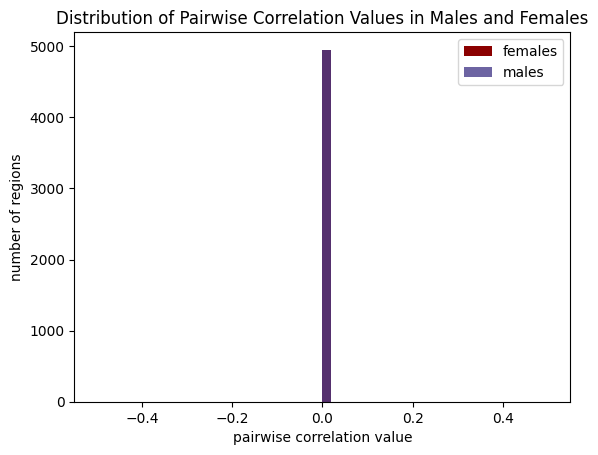

In [22]:
bins = 50
plt.hist(get_upper_triangular(m_most_diff).flatten(), bins=bins, label="females", color="darkred")
plt.hist(get_upper_triangular(f_most_diff).flatten(), bins=bins, label="males", alpha=0.8, color="darkslateblue")

plt.xlabel('pairwise correlation value')
plt.ylabel('number of regions')
plt.title('Distribution of Pairwise Correlation Values in Males and Females')
plt.legend()

plt.show()

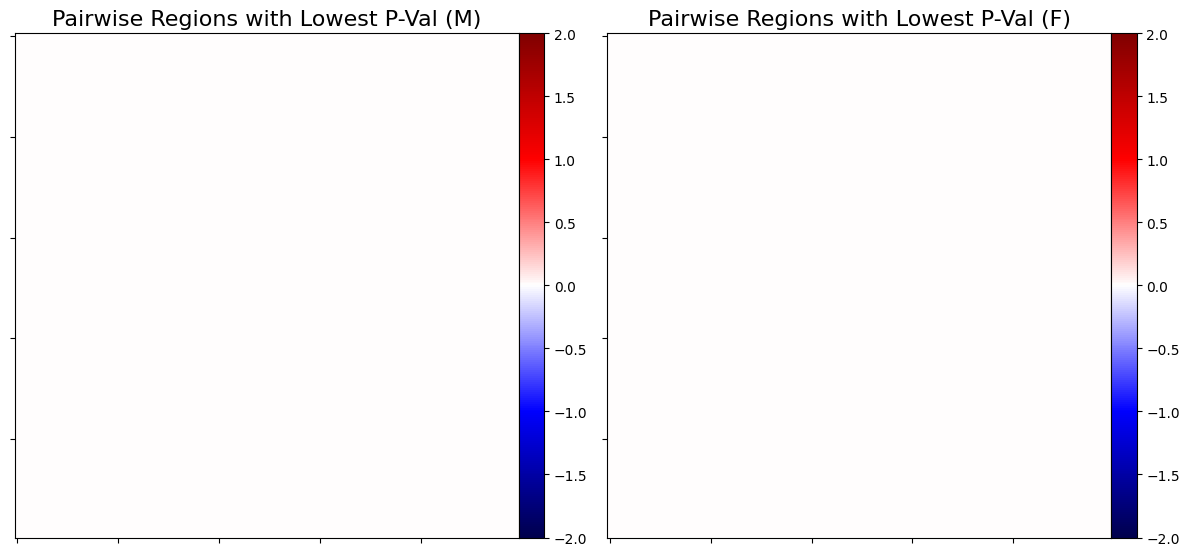

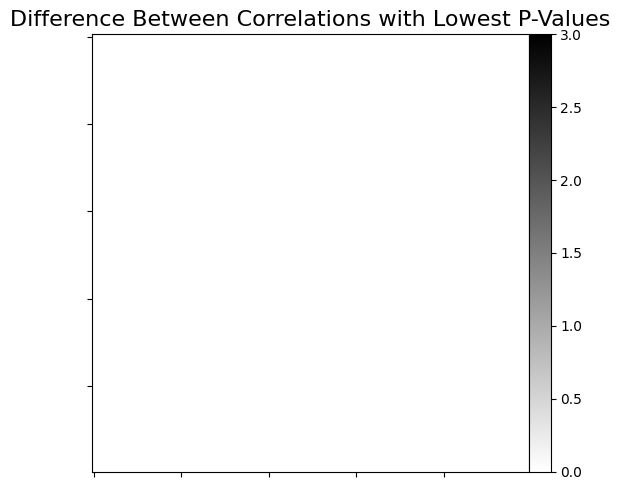

In [23]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first matrix on the left
plotting.plot_matrix(m_most_diff, colorbar=True, vmax=2, vmin=-2, title="Pairwise Regions with Lowest P-Val (M)", axes=axes[0], cmap='seismic')

# Plot the second matrix on the right
plotting.plot_matrix(f_most_diff, colorbar=True, vmax=2, vmin=-2, title="Pairwise Regions with Lowest P-Val (F)", axes=axes[1], cmap='seismic')

plotting.plot_matrix( # visualize element-wise difference of averages
    np.abs(m_most_diff - f_most_diff), colorbar=True, vmax=3, vmin=0, title = "Difference Between Correlations with Lowest P-Values", cmap='binary')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()